In [1]:
import numpy as np
from copy import deepcopy
import astropy.io.ascii as asci
from astropy.time import Time

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms

In [3]:
name = "ZTF21aanxhjv"

z = 0.0180
tmax = 59321

# XRT max and min count rates
crmax = 2.1
crmin = 0.0012

xmin = 59262
xmax = Time("2022-04-14T00:00:00").mjd 

In [4]:
def add_rband_lc(ax):
    D = cosmo.luminosity_distance([z])[0].value * 1e+6 # in pc
    dis_mod = 5*np.log10(D/10)

    myfilter = "UVM2.uvot"
    myfilter1 = "r.ztf"
    #myfilter1 = "g.ztf"
    ########## plot model light curve ##########
    for xx in [myfilter, myfilter1]:
        if xx == "UVM2.uvot":
            cc = "purple"
            mylabel = r"$uvm2_{\rm UVOT}$"
            marker = "s"
        elif xx == "r.ztf":
            cc = "crimson"
            mylabel = r"$r_{\rm ZTF}$"
            marker = "o"
        elif xx == "g.ztf":
            cc = "royalblue"
            mylabel = r"$g_{\rm ZTF}$"
            marker = "o"
        mod = np.loadtxt("../data/opt_lc//mod_%s.txt"%xx)
        mod = mod[mod[:,0]>-55]
        ix = mod[:,3]<0.3
        mod = mod[ix]
        print (xx, "max error = %.2f"%(max(mod[:,3])))
        mjd_mod = mod[:,0] * (1+z) + tmax
        mod_upp = mod[:,4]+mod[:,3] - dis_mod
        mod_low = mod[:,4]-mod[:,3] - dis_mod
        
        temp = np.where(np.diff(mod[:,0])!=1)[0]
        if len(temp) == 0:
            print ("no truncation")
            ax.fill_between(mjd_mod, mod_upp, mod_low,
                        color=cc, alpha=0.2)
        else:
            temp += 1
            for j in range(len(temp)+1):
                if j==0:
                    id1 = 0
                else:
                    id1 = temp[j-1]
                if j == len(temp):
                    id2 = -1
                else:
                    id2 = temp[j]
                print (j, id1, id2)
                ax.fill_between(mjd_mod[id1:id2], mod_upp[id1:id2], mod_low[id1:id2],
                                color=cc, alpha=0.2)
        
        filename1 = "../data/opt_lc/%s_grouped_lc.dat"%(name)
        tb = asci.read(filename1)
        tbr = tb[tb["filter"]==xx]
        
        SNT = 2
        ind = tbr["uJy.0"] > (tbr["duJy.0"]*SNT)
        tbr = tbr[ind]
        
        tbr["mag"] = -2.5 * np.log10(tbr["uJy.0"]/(3631e+6))
        tbr["absmag"] = tbr["mag"] - dis_mod
        tbr["emag"] = 2.5 / np.log(10) * tbr["duJy.0"] / tbr["uJy.0"]
        ax.errorbar(tbr["mjd"], tbr["absmag"], tbr["emag"],
                    fmt = marker, color = cc, label = mylabel, markersize= 3.5)
    
    
    ax.set_ylim(-13.7, -19)
    ax.tick_params(which = 'major', length = 4, top=True, direction = "in", 
                   right = True)
    ax.tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                   right = True)
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.2))
    ax.set_ylabel("Absolute mag")
    
    ########## upper x axis ##########
    # show rest-frame days since g-band max
    axi1 = ax.twiny()
    axi1.tick_params(which = 'major', length = 4, direction = "in")
    axi1.tick_params(which = 'minor', length = 2, direction = "in")
    
    xlims1 = ((xmin-tmax)/(1+z), (xmax-tmax)/(1+z))
    
    xmajor = 50
    xminor = 10
        
    xticks1_label = create_new_xticks1(xlims1, xmajor, xminor, which = "major")
    xticks1_real = []
    for x in xticks1_label:
        xticks1_real.append(x*(1+z)+tmax)
    xticks1_real = np.array(xticks1_real)
    
    xticks1_label_minor = create_new_xticks1(xlims1, xmajor, xminor, which = "minor")
    xticks1_real_minor = []
    for x in xticks1_label_minor:
        xticks1_real_minor.append(x*(1+z)+tmax)
    xticks1_real_minor = np.array(xticks1_real_minor)
    
    axi1.set_xticks(xticks1_real, minor = False)
    axi1.set_xticks(xticks1_real_minor, minor = True)
    axi1.set_xlim(xmin, xmax)
    axi1.set_xticklabels(xticks1_label)
    axi1.set_xlabel("Rest-frame days since optical peak")

In [5]:
def add_nicer_lc(ax1, ax2):
    filename = "../data/nicer/nicer_summary_obsid.dat"
    dt1 = asci.read(filename)
    dt0 = dt1[dt1["isdet"]=='False']
    dt1 = dt1[dt1["isdet"]=='True']
    dt1 = dt1[dt1["HR_unc"]<0.4]

    ########## right y axis: count rate ##########
    color = "darkgoldenrod"
    color_upp = "goldenrod"
    lw = 1
    ms = 3
    ax1.plot(dt0["mjd"].data, dt0["rate_upp"].data,
             marker = "v", color = color_upp, linestyle = "none")
    
    ax1.errorbar(dt1["mjd"], dt1["rate_net_a"], dt1["rate_net_a_unc"], fmt = ".", color = color, zorder = 1,
                 linewidth = lw, markersize = ms,
                 label = "$NICER$")
    ax1.semilogy()
    
    #ax2 = axs[2].twinx()
    ax2.errorbar(dt1["mjd"], dt1["HR"], dt1["HR_unc"], fmt = ".", color = color, zorder = 1,
                 linewidth = lw, markersize = ms)
    
    ###### formatting 
    ymax1 = 12
    ymin1 = 1.2e-2
    
    ymax2 = 0.15
    ymin2 = -1.35
    
    ax1.set_ylim(ymin1, ymax1)
    ax2.set_ylim(ymin2, ymax2)
    
    ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    ax1.tick_params(which = 'major', length = 4, top=True, direction = "in", 
                   right = True)
    ax1.tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                   right = True)
    ax2.tick_params(which = 'major', length = 4, top=True, direction = "in", 
                   right = True)
    ax2.tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                   right = True)
    
    ax1.set_ylabel("$NICER$ 0.3--4 keV (count/s)", color = color)
    ax2.set_ylabel("$NICER$ HR", color = color)
    ax1.tick_params(axis='y', colors=color)
    ax2.tick_params(axis='y', colors=color)
    ax1.tick_params(axis='y', colors=color, which = "minor")
    ax2.tick_params(axis='y', colors=color, which = "minor")
   
    ax1.set_xlim(xmin, xmax)
    ax2.set_xlim(xmin, xmax)

In [6]:
def custom_ax_xrt(axL, axHR):
    
    majorx = 50
    minorx = 10

    axHR.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    axHR.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    axL.xaxis.set_major_locator(plt.MultipleLocator(majorx))
    axL.xaxis.set_minor_locator(plt.MultipleLocator(minorx))
    
    axHR.tick_params(which = 'major', length = 4, top=True, direction = "in", 
                   right = True)
    axHR.tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                   right = True)
    axL.tick_params(which = 'major', length = 4, top=True, direction = "in", 
                   right = True)
    axL.tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                   right = True)
    axL.set_ylabel("XRT 0.3--10 keV (count/s)")
    axHR.set_ylabel("XRT HR")
    
    axL.set_ylim(crmin, crmax)
    axL.semilogy()
    
    HRmin = -1.3
    HRmax = 0.8
    axHR.set_ylim(HRmin, HRmax)

In [7]:
def add_Xepochs(axL, axHR):
    # ========================== add XMM-Newton epochs ==========================
    # DATE-OBS= '2021-08-04T02:30:04' / Start Time (UTC) of exposure                  
    # DATE-END= '2021-08-04T04:24:25'
    color = "darkcyan"
    ts = Time(['2021-08-04T02:30:04', '2021-08-04T04:24:25']).mjd
    #phases = (ts - tmax) / (1+z)
    axL.fill_between(ts, crmin, crmax, color = color, alpha = 0.7)
    axL.text(ts[-1]+1.5, 1.6e-3, "$XMM$ E1", color = color, rotation = 90)
    
    ts = Time(['2022-01-25T02:30:04', '2022-01-25T10:24:25']).mjd
    #phases = (ts - tmax) / (1+z)
    axL.fill_between(ts, crmin, crmax, color = color, alpha = 0.7)
    axL.text(ts[-1]+1.5, 1.6e-3, "$XMM$ E2", color = color, rotation = 90)
    
    # ========================== add NuSTAR epochs ==========================
    color = "b"
    # NuSTAR epoch 1
    ts = Time(['2021-11-18T19:50:28', '2021-11-19T21:00:00']).mjd
    axL.fill_between(ts, crmin, crmax, color = color, alpha = 0.4)
    axL.text(ts[-1]+1.5, 1.6e-3, "$NuSTAR$ E1", color = color, rotation = 90)
    
    # NuSTAR epoch 2 (preliminary schedul)
    ts = Time(['2022-01-10T10:10:12', '2022-01-12T02:00:00']).mjd
    axL.fill_between(ts, crmin, crmax, color = color, alpha = 0.4)
    axL.text(ts[-1], 1.6e-3, "$NuSTAR$ E2", color = color, rotation = 90)
    
    axL.set_xlim(xmin, xmax)
    axHR.set_xlim(xmin, xmax)

In [8]:
def create_new_xticks1(xlims1, xmajor, xminor, which = "major"):
    xticks1_new = []
    if which=="major":
        candi = np.arange(-200, 2000, xmajor)
    else:
        candi = np.arange(-200, 2000, xminor)
    for x in candi:
        if x>xlims1[0] and x<xlims1[1]:
            xticks1_new.append(x)
    xticks1_new = np.array(xticks1_new)
    return xticks1_new

In [9]:
def add_xrt_lc(ax1, ax2, ax1_left):
    lcfolder = "../data/xrt/"
    lc_all = asci.read(lcfolder+"lc_1.dat") # all
    lc_s = asci.read(lcfolder+"lc_4.dat") # soft
    lc_h = asci.read(lcfolder+"lc_5.dat") # hard
    
    h = lc_h["count"].data
    h_unc = lc_h["count_err"].data
    s = lc_s["count"].data
    s_unc = lc_s["count_err"].data
    HR = (h-s) / (h+s)
    HR_unc = 2 * s * np.sqrt(h_unc**2 + s_unc**2) / (h+s)**2
    
    rate = lc_all["rate"].data
    rate_unc = lc_all["rate_err"].data
    
    mjds = lc_all["mjd"].data
    
    ix_nondet = (mjds>60010)&(mjds<60200)
    ix = (rate > rate_unc) & (~ix_nondet)
    
    ax1.errorbar(mjds[ix], rate[ix], rate_unc[ix], fmt = ".k", zorder = 2)
    ax1_left.errorbar(0, 0.1, 0.01, fmt = ".k", zorder = 2,
                 label = "XRT")
    add_upplim(ax1)
    
    ax2.errorbar(mjds[ix], HR[ix], HR_unc[ix], fmt = ".k", zorder = 2)
    
    #axs[1].semilogy()
    custom_ax_xrt(ax1, ax2)

In [10]:
def add_upplim(ax):
    name = 'ZTF21aanxhjv'
    sum_name = "../data/xrt/%s_summary.dat"%(name)
    sumtb = asci.read(sum_name)
    for i in range(len(sumtb)):
        if sumtb["cr_unc"][i] == 0:
            cr_upp = sumtb["cr"][i]
            tstart = sumtb["mjd_start"][i]
            tend= sumtb["mjd_end"][i]
            tmid = (tstart + tend)/2
            tt_unc = (-tstart + tend)/2
            ax.errorbar([tmid], [cr_upp], xerr = [tt_unc], capsize = 2, fmt = "v", color = "grey")

UVM2.uvot max error = 0.30
0 0 23
1 23 231
2 231 280
3 280 363
4 363 438
5 438 -1
r.ztf max error = 0.30
0 0 56
1 56 225
2 225 241
3 241 259
4 259 292
5 292 -1


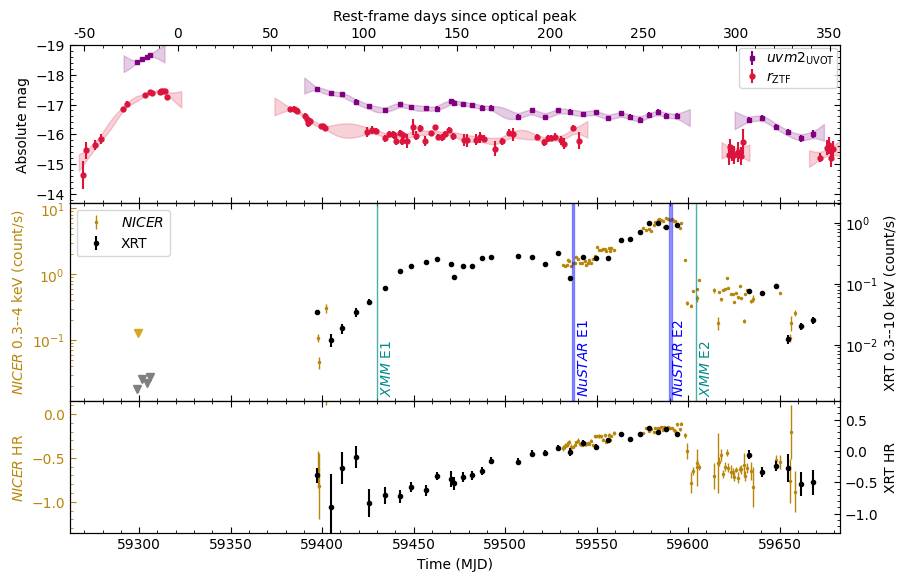

In [11]:
    fig = plt.figure(figsize = (9, 5.8))
    gs = fig.add_gridspec(3, 1, hspace=0, wspace = 0, height_ratios=[1.2,1.5, 1])
    axs = gs.subplots(sharex=True)
    add_rband_lc(axs[0])
    axs[0].legend(borderpad=0.2, labelspacing = 0.2, handlelength = 1.5,
                  handleheight=0.5, handletextpad = 0.2, borderaxespad=0.2,
                  columnspacing=1)
    ### add NICER ldata
    add_nicer_lc(axs[1], axs[2])
    ax1 = axs[1].twinx()
    ax2 = axs[2].twinx()
    add_xrt_lc(ax1, ax2, axs[1])
    add_Xepochs(ax1, ax2)
    axs[1].legend(loc = "upper left")
    axs[2].set_xlabel("Time (MJD)")
    
    plt.tight_layout(rect = (-0.01, -0.01, 1.01, 1.01))